## Adaptive Squeeze Rejection Sampling

### Introduction
In the previous notebook on statistical computing, we talked about rejection sampling as a way to retrieve a sample of data from a distribution, $f$, who is easy to evaluate at any given $x_{i}$, but whose integral (and therefore CDF) is difficult or computationally expensive to compute. Adaptive Squeeze Rejection Sampling is an algorithm that automates the process of selecting an envelope, and introduces an optional _squeezing function_, which can speed up the algorithm depending on the complexity of evaluating $f$.

### A. The Squeeze Function
Recall that, when specifying the envelope function, we selected a function that,
1. Is easy to compute (relative to $f$)
2. Dominates $f$ throughout its domain
3. Approximates $f$ as closely as possible

We then sampled points $Y = y_{1},...,y_{n}$ from the envelope function, $e$, and accepted them with probability $f(Y)/e(Y)$

With a squeezing function (denoted $s$), we also specify a function that is easy to compute, but this function should be _dominated_ by $f$ throughout its domain. Thus this function should attempt to approximate $f$ as closely as possible from below. With the introduction of the squeezing function, we can speed up the rejection sampling algorithm by evaluating the ratio between the squeezing function and the envelope function _before_ evaluating $f(Y)/e(Y)$. If $U \leq s(Y)/e(Y)$, then we know $U \leq f(Y)/e(Y)$ since $s$ was constructed to be less than or equal to $f$ throughout its domain, so we can accept $U$ without ever evaluating $f$.

### B. Conditions to Adaptive Rejection Sampling
In order to apply adaptive rejection sampling, the $log$ of $f$ must be,
1. continuous
2. differentiable
3. _concave_

The first two conditions are somewhat trivial, as they only omit discrete distributions from this process. The third requirement may seem restrictive at first, but many distribution functions are of the inverse exponential family, meaning the $log$ of such a distribution would be concave. For example,

$N(\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{{(x-\mu)}^2}{2\sigma^2}}$

$log(N(\mu,\sigma)) = log(\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{{(x-\mu)}^2}{2\sigma^2}})$ = $-\frac{{(x-\mu)}^2}{2\sigma^2} - \frac{1}{2}log(2\pi\sigma^2)$

which is concave.

### C. Adaptive Squeeze Rejection Sampling Setup
The adaptive squeeze rejection sampling setup is as follows:
1. select $H \geq 2$ points $h_{1},...,h_{H}$ in the domain of $log(f(x))$ such that there is at least one tangent line to $log(f(x))$ whose slope is positive and at least one whose slope is negative.
2. Connect the tangent lines that pass through all $H$ points at their points of intersection. This piecewise function is the _log of the envelope function_.
3. Connect the chords that pass through all $H$ points at their points of intersection. This piecewise function is the _log of the squeezing function_. Note that the squeezing function will have a restricted domain of $[min(h_{1},...,h_{H}),  max(h_{1},...,h_{H})]$ that must be considered when implementing the algorithm.
4. Define $g$ as the envelope function divided by its normalizing constant, which is given by its integral over the entirety of its domain.
5. Compute the _inverse_ of the CDF of $g$, $G^{-1}$. Note the domain of $G^{-1}$ will always be restricted to $(0,1)$ (or $[0,1]$ if the domain of $g$ is bounded, etc.). This is because $G$ is a CDF, so its range is bounded by this interval. Since $G^{-1}$ is the inverse of $G$, it takes on this range as its domain. 

### D. The Adaptive Squeeze Rejection Sampling Algorithm
The algorithm works as follows:
1. Sample $Y$~$g$
2. Sample $U$~Unif$(0,1)$
3. If $U$ lies in the domain of $s$ _and_ $U \leq s(Y)/e(Y)$, keep $Y$ for $x$
4. Else if $U \leq f(Y)/e(Y)$, keep $Y$ for $x$
5. Else reject $Y$
6. repeat $n$ times

Notice the algorithm is identical to that of rejection sampling, with an extra condition for the squeeze function. The squeeze function presents a tradeoff in that it requires the evaluation of an additional condition, but potentially allows for less evaluations of $f$. If $f$ is exceptionally complex to evaluate relative to $s$, the implementation of the squeeze function will significantally improve the computational efficiency of the algorithm. However, if $f$ is a simple function relative to $s$, improvements in efficiency will be trivial at best, and may even be negative.

### E. Adaptive Squeeze Rejection Sampling With an Example $f$
Let

$f(x) = e^{-\frac{|x^3|}{3}}$

Then

$log(f(x)) = -\frac{|x^3|}{3}$

The log of the envelope function can be constructed by taking the tangent lines to the curve at $x = \pm h$ and connecting them at the origin. Define

$j(h,x) = -\frac{d}{dh} log(f(h)) |x| + log(f(h)) + |h|^3 = \frac{2}{3}|h|^3 -h^2|x|$

For this exercise, I define my envelope function as

$e(x) = e^{j(1,x)} = e^{\frac{2}{3}-|x|}$

and therefore

$log(e(x)) = \frac{2}{3} - |x|$

Since I used $h = 1$ in my envelope function, let the squeeze function be defined as

$s(x) = f(1) = e^{-\frac{1}{3}}, x\epsilon(-1,1)$

and therefore

$log(s(x)) = -\frac{1}{3}, x\epsilon(-1,1)$

Now, let's develop $G^{-1}$. Define the density function $g$ as,

$g(y) = \frac{e(y)}{\int_{-\infty}^{\infty} e(x) \; dx} = \frac{e(y)}{2e^\frac{2}{3}}$

Then the CDF of $g$ is given by

$G(y) = \int_{-\infty}^{\infty} g(y) \; dy =$
\begin{cases} 
      e^y/2 & y<0, \\
      1-\frac{1}{2e^y} & y>0 \\
\end{cases}

We can now compute the inverse of the CDF, which is given by

$G^{-1}(u) =$
\begin{cases} 
      log(2u) & u\epsilon(0,\frac{1}{2}), \\
      -log(2(1-u)) & u\epsilon[\frac{1}{2}, 1) \\
\end{cases}


In [178]:
import autograd.numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

<IPython.core.display.Javascript object>


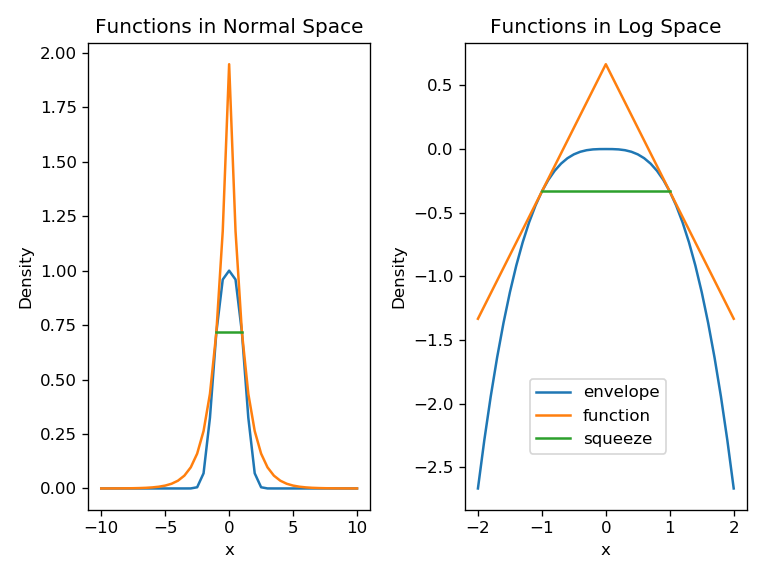

In [180]:
axis = np.linspace(-10,10,41)
axis2 = np.linspace(-2,2,41)

plt.figure()
plt.subplot(1,2,1)
plt.plot(axis,f(axis))
plt.plot(axis,e(axis))
plt.plot(axis[18:23],np.ones(5)*np.exp(-1/3))
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Functions in Normal Space')
plt.show()

plt.subplot(1,2,2)
plt.plot(axis2,logf(axis2))
plt.plot(axis2,loge(axis2))
plt.plot(axis2[10:31],np.ones(21)*-1/3)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend(['envelope','function','squeeze'],loc='center left', bbox_to_anchor=(0.2, 0.2))
plt.title('Functions in Log Space')
plt.show()

Above is an illustration of $f$ along with our envelope and squeeze functions. Notice that $e$ dominates $f$ across its domain, and $f$ dominates $s$ across its domain. Now that we have computed all the necessary functions, we can sample from $f$.

In [179]:
logf = lambda x: -np.abs(x**(3))/3
loge = lambda x: 2/3 - np.abs(x)
logs = lambda x: -1/3 if x >= -1 and x <= 1 else None

f = lambda x: np.exp(logf(x))
e = lambda x: np.exp(loge(x))
s = lambda x: np.exp(logs(x)) if x >= -1 and x <= 1 else None

Ginv = lambda y: np.log(2*y) if y <0.5 else -np.log(2*(1-y))

runif = lambda: np.random.uniform(size=1)[0]

def asrs(n):
    Y = np.zeros(n)
    draws = 0
    accepted = 0
    squeeze = 0
    
    while accepted < n:
        g = Ginv(runif())
        u = runif()
        if g >= -1 and g <= 1 and u < s(g)/e(g):
            Y[accepted] = g
            accepted+=1
            squeeze+=1
        elif u < f(g)/e(g):
            Y[accepted] = g
            accepted+=1
        draws+=1
    
    ac_ratio = accepted/draws
    sq_ratio = squeeze/draws
    
    return [Y, ac_ratio, sq_ratio]

Let's generate a sample of size 100,000 using our algorithm,

In [181]:
listvals = asrs(10**5)

<IPython.core.display.Javascript object>


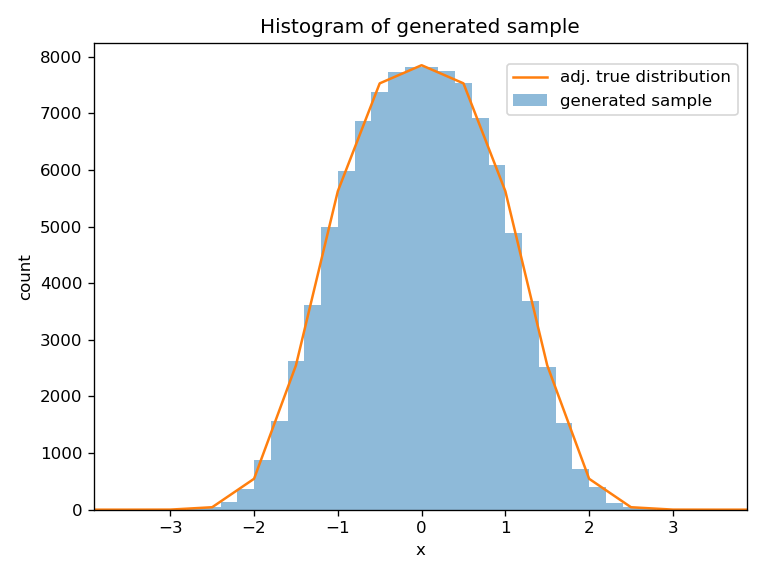

Text(0,0.5,'count')

In [213]:
plt.figure()
bins = np.arange(-10, 10, 0.2)
plt.hist(listvals[0], bins=bins, alpha=0.5)
plt.plot(axis,7850*f(axis))
plt.xlim([min(listvals[0])-1, max(listvals[0])+1])
plt.legend(['adj. true distribution','generated sample'],loc='center left', bbox_to_anchor=(0.62, 0.9))
plt.title('Histogram of generated sample')
plt.xlabel('x')
plt.ylabel('count')

As you can see from the figure above, the distribution of our sample closely mirrors that of $f$, despite the fact that we never sampled from $f$; that's the power of rejection sampling.

The theoretical acceptance ratio of the envelope function is given by

$\frac{\int_{-\infty}^{\infty} f(x) \; dx}{\int_{-\infty}^{\infty} e(x) \; dx}$

In [182]:
integrate.quad(f, -1 * np.inf, np.inf)[0]/integrate.quad(e, -1 * np.inf, np.inf)[0]

0.6612295568632603

The experimental envelope ratio attained from this simulation is

In [183]:
listvals[1]

0.6595783974883255

The theoretical squeeze ratio of the function is given by

$\frac{\int_{-\infty}^{\infty} s(x) \; dx}{\int_{-\infty}^{\infty} e(x) \; dx}$

In [184]:
integrate.quad(s, -1, 1)[0]/integrate.quad(e, -1 * np.inf, np.inf)[0]

0.36787944117144233

The experimental squeeze ratio attained from this simulation is

In [185]:
listvals[2]

0.3680051710946363